In [1]:

### Install packages

!pip install torch
!pip install torchvision
!pip install torchsummary

## Packages loading



In [2]:
#import PIL.ImageOps

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

#!mkdir -p drive -v


Mounted at /content/gdrive


In [4]:
import os

%cd /content/gdrive/MyDrive/Stage_M2_Jean-Eudes

!pwd

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes
/content/gdrive/MyDrive/Stage_M2_Jean-Eudes


In [5]:

dir_path  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes'
dirs = os.listdir(dir_path)

package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
!export PYTHON_PATH=package_path

lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=package_path:lib_package_path
!export PYTHON_PATH=package_path:lib_package_path

print (package_path)

os.chdir(package_path)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/binary-stochastic-neurons-master/


In [6]:
### Import packages from https://github.com/Wizaron/binary-stochastic-neurons
from activations import DeterministicBinaryActivation, StochasticBinaryActivation
from utils import Hardsigmoid

In [7]:
### PYTHON PATH pour mes fichiers


cwd = os.getcwd()
dir_mypackages  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/MonCode/'
dirs = os.listdir(dir_path)

#package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
#!export PYTHON_PATH=package_path

#lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=$PYTHONPATH:dir_mypackages
!export PYTHON_PATH=$PYTHON_PATH:dir_mypackages

print (dir_mypackages)

os.chdir(dir_mypackages)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/MonCode/


 
# <font color='darkblue'> Preliminaries</font>

In [8]:

### Imports Packages standards

import itertools
import math
import time
import numpy as np
from easydict import EasyDict as edict
import tempfile
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr



In [9]:
### Init variables globales

Sauve_figures = False
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
print(device)

cpu



# <font color='darkblue'> Data</font>

In [11]:

n_epochs = 10
batch_size_train = 128
batch_size_test = 256 
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:

#t = torchvision.transforms.Compose([
#                       torchvision.transforms.ToTensor(),
#                       torchvision.transforms.Normalize(mean=(0), std=(1))]
#                       )

mnist_train = torchvision.datasets.MNIST(root=tempfile.gettempdir(), train=True, download=True,) #'./'

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))

mnist_test = torchvision.datasets.MNIST(root=tempfile.gettempdir(),train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



In [13]:
class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, input_1):

        self.x_mnist_data = x_mnist_data
        self.input_1 = input_1

        
    def __getitem__(self, index):
        sample = {'x_mnist_data': self.x_mnist_data[index], 'input_1': self.input_1[index]}
        return sample
    
    def __len__(self):
        return len(self.x_mnist_data)

In [14]:

dataset = customDataset(X_mnist_train.to(device),  torch.ones((len(mnist_train),1,1,1)).float().to(device))

train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

dataset_test = customDataset(X_mnist_test.to(device), torch.ones((len(mnist_test),1,1,1)).float().to(device))

test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False )

In [15]:
X_mnist_train.shape

torch.Size([60000, 1, 28, 28])

In [16]:
def transform_data(x_train, x_test, normalize = "none"): 

  ## x_train, x_test are basically : X_mnist_train and X_mnist_test

  train_size = x_train.shape[0]
  test_size= x_test.shape[0]

  x_train = np.fft.fft2(x_train, axes=(2,3)) ##x_train is of shape 60000,1,28,28 . fft direct : il est non centré

  x_test = np.fft.fft2(x_test, axes=(2,3)) ##x_test is of shape 10000,1,28,28. fft direct : il est non centré      

  if normalize == "minmax":
    x_train = x_train/np.max(np.abs(x_train)) 
    x_test = x_test/np.max(np.abs(x_test)) 
  
  elif normalize == "standartscale":
    x_train = ( x_train - np.mean(x_train) ) / np.std(x_train)
    x_test = ( x_test - np.mean(x_test) ) / np.std(x_test)

  elif normalize == "none":
    pass

  x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device)
  x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

  dataset = customDataset(x_train, torch.ones((train_size,1,1,1)).float().to(device))
  train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

  dataset_test = customDataset(x_test , torch.ones((test_size,1,1,1)).float().to(device))
  test_loader = DataLoader(x_test, batch_size=batch_size_test, shuffle=False )

  return train_loader, test_loader
  


In [17]:
ft_train_loader, ft_test_loader = transform_data(X_mnist_train, X_mnist_test,  normalize = "none")


# <font color='darkblue'> Tools</font>

In [18]:

class SparsifyBase(nn.Module):
    def __init__(self, sparse_ratio=0.5):
        super(SparsifyBase, self).__init__()
        self.sr = sparse_ratio
        self.preact = None
        self.act = None

    def get_activation(self):
        def hook(model, input, output):
            self.preact = input[0].cpu().detach().clone()
            self.act = output.cpu().detach().clone()
        return hook

    def record_activation(self):
        self.register_forward_hook(self.get_activation())


class Sparsify1D(SparsifyBase):
    def __init__(self, sparse_ratio=0.5):
        super(Sparsify1D, self).__init__()
        self.sr = sparse_ratio

    def forward(self, x):
        k = int(self.sr *x.shape[1])
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

class Sparsify1D_kactive(SparsifyBase):
    def __init__(self, k=1):
        super(Sparsify1D_kactive, self).__init__()
        self.k = k

    def forward(self, x):
        k = self.k
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x
      
    
class Sparsify1D_kactiveIOnline(SparsifyBase):
    def __init__(self, height_mask, width_mask, k=None, k_per_under_mask =None):                                          
        super(Sparsify1D_kactiveIOnline, self).__init__()
                
        self.height_mask = height_mask
        self.width_mask = width_mask

        assert (k != None and k_per_under_mask ==None) or (k==None and k_per_under_mask !=None)
        if k != None and k_per_under_mask ==None:
          self.k = k  ## here k will be the total number of points we keep in the whole mask of 28*28 ; and k_per_under_mask the number of points kept in the sub mask
          self.k_per_under_mask = math.ceil((self.height_mask)*(self.width_mask)*k / 28*28)  ##règle de trois: 20 -> 28*28 ; ? ->5*5
        
        elif k==None and k_per_under_mask !=None:
          self.k_per_under_mask = k_per_under_mask
          self.k = math.ceil( k_per_under_mask*28*28/(self.height_mask * self.width_mask) ) ##penser à changer 28*28
                            

    def forward(self, x):#, k=0):
        #if (k==0):
        #  k = self.k
        #else:
        #  self.k = k
        topval = x.topk(self.k_per_under_mask, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x


In [19]:

#SPIRiT as single conv layer with kernel(centre) = 0
class RealSpirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(RealSpirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        self.activation = config.spirit_activation
        if self.config.batch_norm==True:
          self.bn_layer = nn.BatchNorm2d(self.ncoils)
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        #self.conv0 = nn.Conv2d(in_channels= self.ncoils * self.nslices , out_channels=self.ncoils*self.nslices, kernel_size=self.kernel_size, bias=False,  padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))                                                   
        self.conv0 = nn.Conv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))                                   


    def forward(self, x):          
        
        with torch.no_grad():
            self.conv0.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0

        if self.activation =="relu":
          z= F.relu(self.conv0(x)) 
        elif self.activation =="leaky_relu":
          z= F.leaky_relu(self.conv0(x))
        elif self.activation =="none":
          z= self.conv0(x)

        if self.config.batch_norm==True:
          return self.bn_layer(z)
        else:
          return z

        
class SpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_img: torch.Tensor, #current_kspace: torch.Tensor,
        ref_img: torch.Tensor, #ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_img)
        
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_img, mask) #out = torch.multiply(x,1-mask) + ref_img
        #torch.mul(ref_img, mask)
        return out
    
    
#Stack SpiritConv N times
class stackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block

        #intermediate/auxiliar reconstruction
        
        self.body = nn.ModuleList(
            [SpiritConvBlock(RealSpirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_img: torch.Tensor, #masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
      img_pred = masked_img.clone()  #kspace_pred = masked_kspace.clone()

      for stack in self.body:
          img_pred = stack(img_pred, masked_img, mask)
          #kspace_pred = stack(kspace_pred, masked_kspace, mask)
      
      return img_pred #kspace_pred

      

In [20]:
class complexConv2d(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, padding = 0,dilation=1, groups=1, bias=False):
        
        super(complexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self,input_r, input_i):
        return self.conv_r(input_r)-self.conv_i(input_i), \
               self.conv_r(input_i)+self.conv_i(input_r)


#SPIRiT as single conv layer with kernel(centre) = 0
class Complexspirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(Complexspirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        self.conv1 = complexConv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))
    
    def forward(self, x):
        
        (x_real,x_img) = x[...,0],x[...,1]  
        
        with torch.no_grad():
            self.conv1.conv_r.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
            self.conv1.conv_i.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
        
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        
        z= torch.cat((x_real,x_img),-1)

        if self.activation =="relu":
          z= F.relu(z)
        elif self.activation =="leaky_relu":
          z= F.leaky_relu(z)
        elif self.activation =="none":
          z= z #this is not well writen

        if self.config.batch_norm==True:
          return self.bn_layer(z)
        else:
          return z

        
class ComplexSpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_kspace)
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_kspace, mask) #torch.multiply(x,~mask) + ref_kspace
        
        return out
    
    
#Stack SpiritConv N times
class ComplexstackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        #define local variables
        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block
        
        self.body = nn.ModuleList(
            [ComplexSpiritConvBlock(Complexspirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
        kspace_pred = masked_kspace.clone()

        for stack in self.body:
            kspace_pred = stack(kspace_pred, masked_kspace, mask)
        
        return kspace_pred




# <font color='darkblue'> Model</font>




In [21]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

In [22]:
class Net(nn.Module):

    def __init__(self, bin_act_type = "determinist", k_per_under_mask = 2,config=None):
        super(Net, self).__init__()

        self.img_h = config.slice_dim[0] ##nb rows for the inmput image
        self.img_w = config.slice_dim[1] ##nb col for the inmput image
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.k_per_under_mask = k_per_under_mask
        self.config = config
        self.std_noise = config.std_noise
        self.dropout_proba = config.dropout_proba                

        self.bin_act_type = bin_act_type
        self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (self.height_mask, self.width_mask), groups=1, bias=False)      
        
        self.DO1 = nn.Dropout(p = self.dropout_proba, inplace=False)
        self.noise = GaussianNoise(self.std_noise)

        self.binary_act_d = DeterministicBinaryActivation(estimator='ST')
        self.binary_act_s = StochasticBinaryActivation(estimator='ST')
        
        self.slope = config.slope #1.0
        self.linear_sp = Sparsify1D_kactiveIOnline(self.height_mask, self.width_mask, k_per_under_mask = self.k_per_under_mask)
        
        if self.config.complexe ==False:
          self.spirit_nn = stackSpirit(self.config) 
          print("stackSpirit")
        elif self.config.complexe ==True:
          self.spirit_nn = ComplexstackSpirit(self.config)
          print("ComplexstackSpirit")    

        if self.config.multicoil == True: 
          self.sensitivity_conv = nn.Conv2d(in_channels = 1, out_channels = self.config.ncoils, kernel_size = (5, 5), groups=1, bias=False, padding="same")  
          self.back_to_img_dim_conv = nn.Conv2d(in_channels =  self.config.ncoils, out_channels =1, kernel_size = (5, 5), groups=1, bias=False, padding="same") 


    def forward(self, x, my_input_1):

        sig_output = F.sigmoid((self.conv_mask(my_input_1)))       
        
        #sig_output= self.DO1(sig_output) # commente dans celui qui fonctionne

        if self.bin_act_type == "determinist": # add noise and use deterministic binary activation with

          sig_output = self.noise(sig_output) # variance plus forte ici
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output) 
                 
          #wta_output = self.linear_sp(sig_output)        
             
          binary_mask = self.binary_act_d([wta_output, self.slope]) #shape : [1,1,self.height_mask, self.width_mask] . WHY NOW [batch_size,1,self.height_mask, self.width_mask]
        
        elif self.bin_act_type == "stochastic": # add noise and use deterministic binary activation with
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output)    
          binary_mask = self.binary_act_s([wta_output, self.slope]) #shape : [1,1,self.height_mask, self.width_mask] . WHY NOW [batch_size,1,self.height_mask, self.width_mask], the mask is specific to each input ?


        ##ajuster la taille du masque à celle de l'image                                                                      
        binary_mask_adj = torch.tile(binary_mask[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28
        ##or change the "one" input and rewrite the conv mask with convtranspose  ,with stride = dim of mask...
        
        
        if self.config.multicoil == True:
          if self.config.complexe ==True: 

              x_real, x_img = x[...,0],x[...,1]  
                        
              x_real_sensitivity  = self.sensitivity_conv(x_real) ; x_img_sensitivity =self.sensitivity_conv(x_img)

              (x_real,x_img) =(torch.unsqueeze(x_real_sensitivity, 4), torch.unsqueeze(x_img_sensitivity, 4))
        
              x = torch.cat((x_real,x_img),-1) #shape [batch_size, 8, 28, 28, 2]

          else:
              x = self.sensitivity_conv(x) #shape [batch_size, 8, 28, 28]
          
                        
        if self.config.complexe ==True:          
          stack_binary_mask_adj = torch.stack((binary_mask_adj, binary_mask_adj), dim=-1,)  # ajouter la dimension complexe , shape : [batch_size, 1, 28,28,2]
          #print("stack_binary_mask_adj ", stack_binary_mask_adj.shape) ; print("x.shape :", x.shape)
          x  = torch.mul(stack_binary_mask_adj,x) 
          reconstructed_img = self.spirit_nn(x, stack_binary_mask_adj) ##more precisely it is the reconstructed "kspace" : [batch_size, 8, 28, 28] or [batch_size, 1, 28, 28]
          print()
                  
        else:

          x  = torch.mul(binary_mask_adj,x) ## shape [batch_size, 1, 28,28]
          #print("x après mul shape: ", x.shape)
          reconstructed_img = self.spirit_nn(x, binary_mask_adj)  

        if self.config.multicoil == True:  
          reconstructed_img = self.back_to_img_dim_conv(reconstructed_img)        


        return reconstructed_img, binary_mask_adj, binary_mask  
                          

In [23]:
# https://stackoverflow.com/questions/51748138/pytorch-how-to-set-requires-grad-false

def weight_init(model):
  #nn.init.normal_(model.senstivity_conv.weight)
  for param in model.sensitivity_conv.parameters():
    param.requires_grad = False



# <font color='darkblue'> Learning</font>



In [24]:
def define_opt(network, lr_mask = 1e-3, lr_other = 1e-2,algo =optim.Adam  ):

  my_list = ['conv_mask.weight']

  params = list(filter(lambda kv: kv[0] in my_list, network.named_parameters()))
  base_params = list(filter(lambda kv: kv[0] not in my_list, network.named_parameters()))
  d = dict((y, x) for x, y in base_params)
  #optimizer_mask = optim.Adam(params,lr=0.001)
  #optimizer_model = optim.Adam(base_params,lr=0.01)

  optimizer = algo([ 
                                {'params': d}, 
                                {'params': network.conv_mask.parameters(), 'lr': lr_mask} 
                                ], lr=lr_other)
  return optimizer
                              

 
# <font color='darkblue'> SPIRiT  reconstruction</font>


In [25]:
def test_spirit_2(network,criterion,config, loader=test_loader):

  network.eval()
  test_loss = 0
  output_array =[]
  input_array = []

  #print("*********** TEST *************")
  with torch.no_grad():
    for batch_idx, sample in enumerate(loader):
      input, ones_data = sample['x_mnist_data'], sample['input_1']
    
      output,  learned_mask_adj, learned_mask = network(input,ones_data) ##here the output is image
      
      #print(f"test : ,{len(output)}")
      
      test_loss += criterion(output, input).item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)

      output_array.append(output) 
      input_array.append(input)        


  test_loss /= len(loader.dataset) ##this the loss on the whole test set

  input_array = np.array(torch.vstack(input_array).cpu())
  output_array = np.array(torch.vstack(output_array).cpu())


  if config.complexe ==True:
    print("input_array shape: ", input_array.shape)
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    input_array = np.abs(input_array)

    output_array_complex = output_array[...,0] +1j* output_array[...,1]
    output_array = np.fft.ifft2(output_array_complex, axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))
    output_array = np.abs(output_array)

  
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
  
  #print('\nTest set: Avg. loss: {:.4f}, SSIM: {} on {} test examples\n'.format(
    #test_loss, ssim(output_array, input_array, data_range=output_array.max() - input_array.min()) , len(test_loader_spirit.dataset) ))
  
  fig, ax = plt.subplots(1,3, figsize=(15,6))
  ax[0].imshow(network.conv_mask.weight.data.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  #ax[0].axis("off")
      
  #print(learned_mask.clone().cpu().shape)
  ax[1].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  ax[1].axis("off")
  
  ax[2].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  ax[2].axis("off")
  plt.show()

  return input_array, output_array, test_loss, learned_mask_adj  



In [26]:
def get_initial_weight_mask(network, data_loader):

  network.eval()

  with torch.no_grad():
    one_batch = next(iter(data_loader))    
    input, ones_data = one_batch['x_mnist_data'], one_batch['input_1']
    init_output, init_learned_mask_adj, init_learned_mask = network(input,ones_data)
    #print(input.shape)


  return network.conv_mask.weight.data.clone().cpu()[0,0,:,:], init_learned_mask_adj.clone().cpu()[0,0,:,:]


In [27]:
def train_spirit_2(n_epochs, network, optimizer, config, saving_path = None,criterion=nn.MSELoss(), loader = train_loader, loader_test = test_loader):  
          
                
    train_losses = []
    test_losses = []
    learned_mask_adj_list = []
    weight_list = []          

    init_weight, init_learned_mask_adj = get_initial_weight_mask(network, data_loader =loader) 
    
    weight_list.append(init_weight); learned_mask_adj_list.append(init_learned_mask_adj)

    plt.imshow(init_learned_mask_adj,cmap = "Greys_r")
    plt.axis("off")
    plt.title("initialisation mask")

    try:
      plt.savefig(os.path.join(saving_path,"initialisation_mask.png")) 
    except:
      pass    

    ##training loop
    for epoch in range(1, n_epochs + 1):
                
        running_loss = 0.0  
        network.train()
        for batch_idx, sample in enumerate(loader):                
            input,  ones_data = sample['x_mnist_data'], sample['input_1']
            optimizer.zero_grad()

            output,  learned_mask_adj, learned_mask = network(input,ones_data)

            loss = criterion(output, input)       #(sum of square)/batch_size*C*h*w
            loss.backward()
            optimizer.step()

                                        
            weight_list.append(network.conv_mask.weight.data.clone().cpu()[0,0,:,:]) ; learned_mask_adj_list.append(learned_mask_adj.clone().cpu()[0,0,:,:])

            #print("nb of pixels changed wrt previous mask : ", (torch.eq(learned_mask_adj_list[-2], learned_mask_adj_list[-1])==False).sum().item() )                        
            #print("nb of pixels changed wrt the initial mask : ", (torch.eq(learned_mask_adj_list[0], learned_mask_adj_list[-1])==False).sum().item()  )
            
            running_loss += loss.item() * input.size(0)  #(sum of square)/C*h*w
             

            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(input), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item())) # this is the loss for a single batch : (sum of square)/batch_size*C*h*w
                
                #inp, out, _, _ = test_spirit_2(network,criterion,config, loader = loader_test) ; plotting_reconst(inp, out,n=4)
                

        epoch_loss = running_loss / len(loader.dataset) #(sum of square)/60000*C*h*w; 60000=batch_size*len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print("test at the end of epoch")
        
        inp_, out_, end_test_loss, epoch_learned_mask_adj = test_spirit_2(network,criterion,config, loader = loader_test) ; test_losses.append(end_test_loss) 

        
        plt.imshow(epoch_learned_mask_adj[0,0,:,:].cpu(),cmap = "Greys_r")
        plt.axis("off")
        plt.title(f"mask_at_the_epoch_{epoch}")
        try:
          plt.savefig(os.path.join(saving_path,f"mask_at_the_epoch_{epoch}.png")) 
        except:
          pass


    delta_pixels = [(torch.eq(learned_mask_adj_list[i], learned_mask_adj_list[i+1])==False).sum().item() \
                    for i in range(len(learned_mask_adj_list)-1)] #list of nb of pixels changed wrt previous mask 

    delta_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i+1]-weight_list[i])))**2).item() \
         for i in range(len(weight_list)-1)] #list of diff in weight wrt previous weight


    delta0_pixels = [(torch.eq(learned_mask_adj_list[0],learned_mask_adj_list[i])==False).sum().item() \
                     for i in range(1,len(learned_mask_adj_list))] #nb of pixels changed wrt the initial mask

    delta0_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i]-weight_list[0])))**2).item() \
              for i in range(1,len(weight_list))]  #list of diff in weight wrt initial weight


    fig, ax = plt.subplots(2,2, figsize=(20,10))

    ax[0,0].plot(range(1,len(delta_pixels)+1), delta_pixels)
    ax[0,0].set_title("nb of pixels changed wrt previous mask")
    ax[0,0].set_xlabel("iterations") # batch_size*nb_epochs
    ax[0,0].set_ylabel("nb of pixels")
    
    ax[0,1].plot(range(1,len(delta_weight)+1),delta_weight)
    ax[0,1].set_title("square diff in weight wrt previous weight")
    ax[0,1].set_xlabel("iterations") 
    ax[0,1].set_ylabel("weight square diff")

    ax[1,0].plot(range(1,len(delta0_pixels)+1),delta0_pixels)
    ax[1,0].set_title("nb of pixels pixels changed wrt the initial mask")
    ax[1,0].set_xlabel("iterations") 
    ax[1,0].set_ylabel("nb of pixels")

    ax[1,1].plot(range(1,len(delta0_weight)+1), delta0_weight)
    ax[1,1].set_title("diff in weight wrt initial weight")
    ax[1,1].set_xlabel("iterations") 
    ax[1,1].set_ylabel("weight square diff")

    try:
      plt.savefig(os.path.join(saving_path,"variations.png")) 
    except:
      pass
    plt.show() 

    return {"train_loss":train_losses, "test_loss":test_losses} 

    

In [28]:
def plotting_reconst(groundtruth, reconstruction,n=3, seed= None, saving_path =None, loader= test_loader):
  ##choose n between 3 and 6
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(loader.dataset), n)

  fig, ax = plt.subplots(2,n, figsize=(15,6))
    #plot some examples of reconstruction and their groundtruth
  for t in range(n):

        ax[0,t].imshow(groundtruth[ random_index[t],0,:,:],cmap = "Greys_r")  
        ax[0,t].set_title("groundtruth")
        ax[0,t].axis("off")        
        ax[1,t].imshow(reconstruction[ random_index[t],0,:,:],cmap = "Greys_r")
        ax[1,t].set_title("reconstruction")
        ax[1,t].axis("off")
  try:
    plt.savefig(saving_path)
  except:
    pass
  plt.show()


In [29]:
def compute_ssim(groundtruth, reconstruction):    

    a = np.moveaxis(groundtruth, 1, -1) ## groundtruth dimension is (N,1,28,28); turn it to (N,28,28,1)
    b =  np.moveaxis(reconstruction, 1, -1)
    ssim_list = []
    psnr_list = []
    for i in range(a.shape[0]):
         ssim_i = ssim(a[i], b[i], data_range=abs(a[i].max() - b[i].min()), multichannel=True )
         psnr_i = psnr(a[i], b[i], data_range=abs(a[i].max() - b[i].min()))
    ssim_list.append(ssim_i)
    psnr_list.append(psnr_i)
    
    ##I double compute, just for comparison
    #ssim_2 = torch_ssim(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction)); psnr_2 = torch_psnr(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction))
    return {"test_ssim": np.mean(ssim_list), "test_psnr": np.mean(psnr_list)}#,"test_ssim2": ssim_2, "test_psnr2":psnr_2 }

In [30]:
def plot_loss(dictionay,title="reconstruction loss", test=False, saving_path = None):
  plt.plot(np.arange(1, len(dictionay["train_loss"])+1), dictionay["train_loss"], label = "train loss") 
  if test==True:
    plt.plot(np.arange(1, len(dictionay["test_loss"])+1), dictionay["test_loss"], label = "test loss")
  plt.title(f"{title}")
  plt.ylabel("loss")
  plt.xlabel("epoch") 
  plt.legend()
  try:
    plt.savefig(saving_path) 
  except:
    pass

  plt.show()

In [31]:
def make_grid_search_4(initial_config, spirit_block_list, std_noise_list, bn_list, lr_mask_list, lr_other_list,critere, return_model =False, loader_train= train_loader,loader_test =test_loader):

  config_current = edict(initial_config.copy())

  df = pd.DataFrame(columns=['bloc','batch_norm','std_noise','lr_mask','lr_other','test_ssim','test_psnr','test_loss'])

  model_list = []
  for bloc in spirit_block_list :
      for std_noise in std_noise_list: 
        for bn in bn_list:
          for lr_mask in lr_mask_list:
            for lr_other in lr_other_list:

              dir_name = f"spirit_bloc_{bloc}_batch_norm_{bn}_std_noise_{std_noise}_lr_mask_{lr_mask}_lr_other_{lr_other}"

              try:
                  save_path = os.path.join(config_current.main_directory, dir_name)
                  os.mkdir(save_path)  
              except:
                  pass
          
              config_current.spirit_block = bloc; config_current.batch_norm = bn; config_current.std_noise = std_noise; config_current.batch_norm = bn; config_current.lr_mask = lr_mask; config_current.lr_other = lr_other            

              print("#################################################################")
              
              print(f"spirit_bloc : {bloc} ; batch_norm : {bn}; std_noise : {std_noise}; lr_mask : {lr_mask}; lr_other : {lr_other}")

              reconst_network = Net(bin_act_type = "determinist", k_per_under_mask = 157, config =config_current).to(device)          

              if config_current.multicoil ==True:
                weight_init(reconst_network)
              
              optimizer_det = define_opt(reconst_network, lr_mask = lr_mask, lr_other = lr_other, algo = optim.Adam)

              dico_spirit_loss = train_spirit_2(10, reconst_network, optimizer_det, config_current, saving_path = save_path, criterion = critere, loader = loader_train, loader_test = loader_test)

              if return_model==True:

                model_list.append(reconst_network) ##for future, save the model, and write the path to the model file

              plot_loss(dico_spirit_loss,title=f"reconstruction loss for bloc : {bloc} ; batch_norm : {bn}; std_noise : {std_noise}; \
              lr_mask : {lr_mask}; lr_other : {lr_other}", test=False, saving_path = os.path.join(save_path,"loss_curve.png"))

              test_input, test_output,test_loss, _ = test_spirit_2(reconst_network,criterion=critere, config =config_current, loader = loader_test)  

              plotting_reconst(test_input , test_output, n=4, seed= 123, saving_path =os.path.join(save_path,"reconst_examples.png"))
            
              metrics = compute_ssim(test_input ,test_output)

              print("average ssim and psnr on test set", metrics)

              line ={"bloc" : bloc, "batch_norm": bn,  "std_noise" : std_noise , "lr_mask" :lr_mask , "lr_other": lr_other}
                          
              line.update(metrics); line["test_loss"] = test_loss

              df = df.append(line, ignore_index=True)            
                                    
              config_current = edict(initial_config.copy())  

  df.to_csv(os.path.join(config_current.main_directory, "result_grid_search.csv"), sep='\t',index=True)
  
  print("##########   FIN   ##########")

  if return_model ==True:
    return model_list


In [32]:
os.chdir("/content")

 
## <font color='darkblue'> multicoil image </font>


#################################################################
spirit_bloc : 5 ; batch_norm : False; std_noise : 0.05; lr_mask : 0.001; lr_other : 0.01
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.1404
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0109
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0082
test at the end of epoch

Test set: Avg. loss: 0.0757


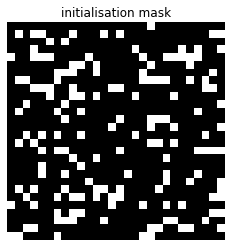

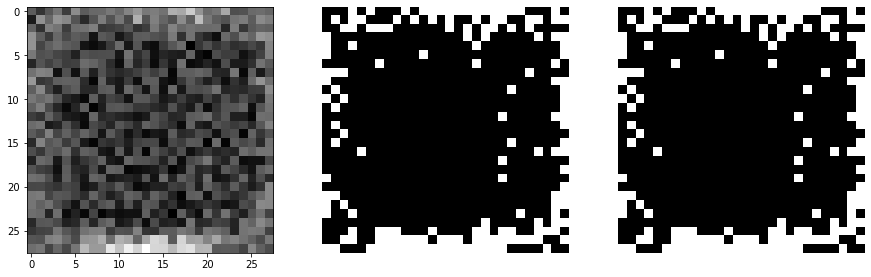

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0074
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0070
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0062
test at the end of epoch

Test set: Avg. loss: 0.0685


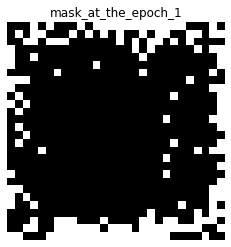

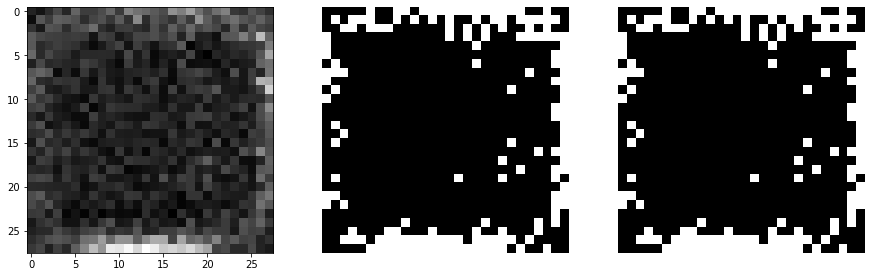

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0060
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0063
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0062
test at the end of epoch

Test set: Avg. loss: 0.0542


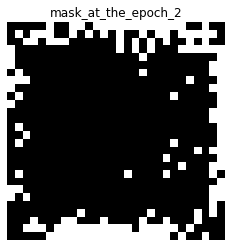

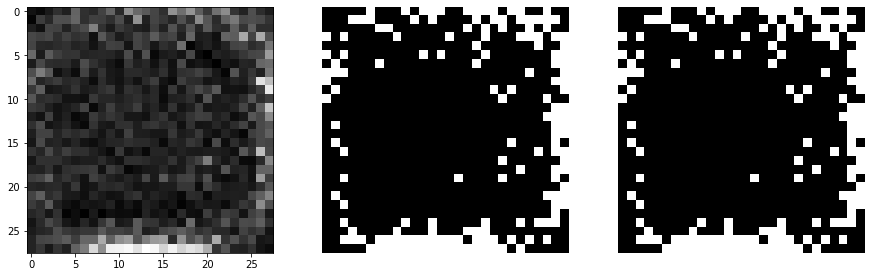

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0062
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0067
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0059
test at the end of epoch

Test set: Avg. loss: 0.0161


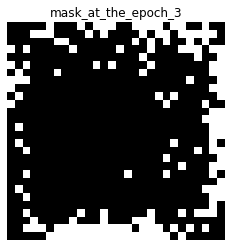

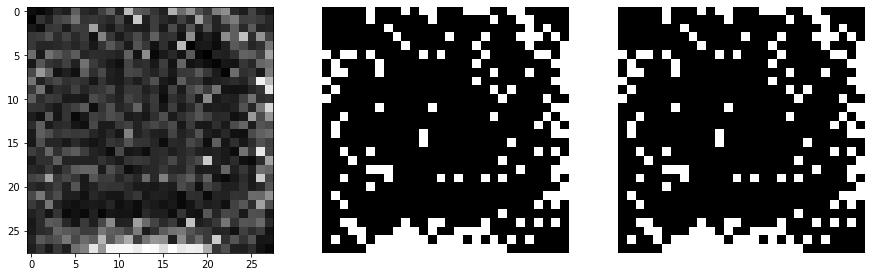

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0059
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0055
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0050
test at the end of epoch

Test set: Avg. loss: 0.0078


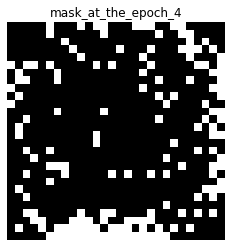

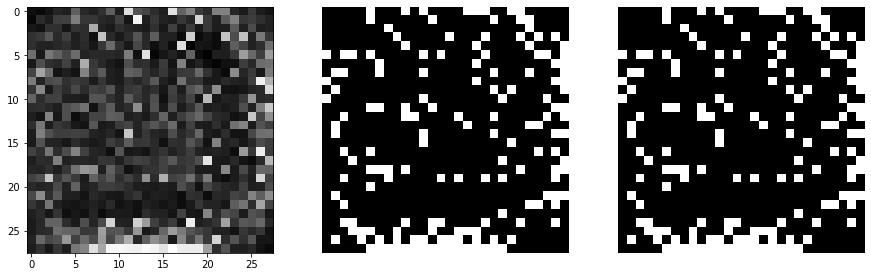

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0057
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0044
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0041
test at the end of epoch

Test set: Avg. loss: 0.0036


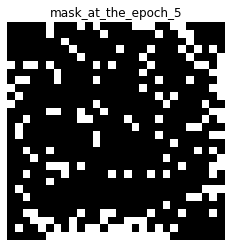

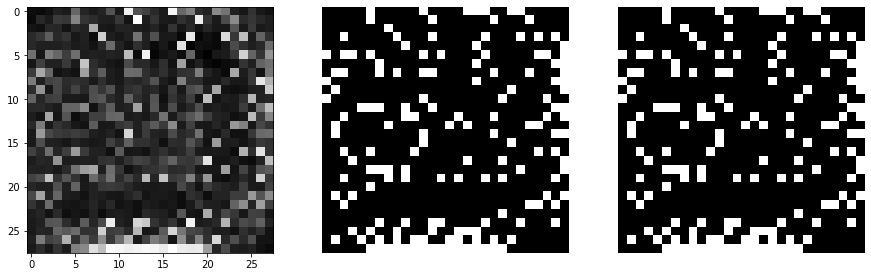

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0039
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0040
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0115
test at the end of epoch

Test set: Avg. loss: 0.0037


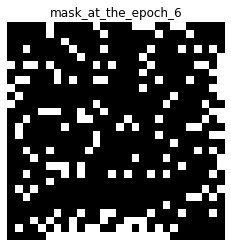

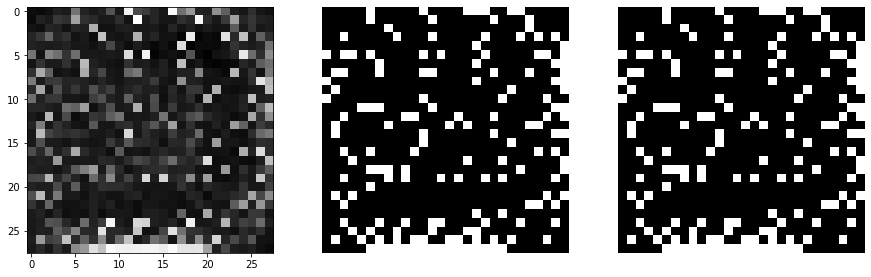

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0042
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0038
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0035
test at the end of epoch

Test set: Avg. loss: 0.0035


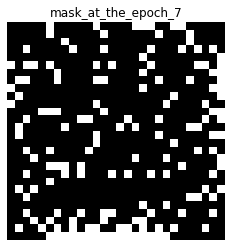

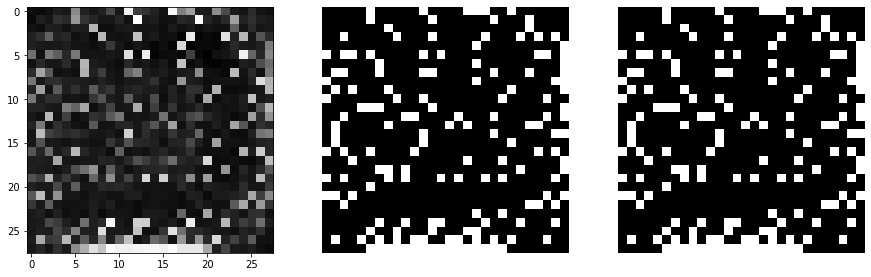

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0039
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0033
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0034
test at the end of epoch

Test set: Avg. loss: 0.0029


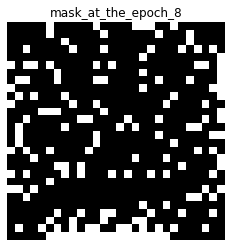

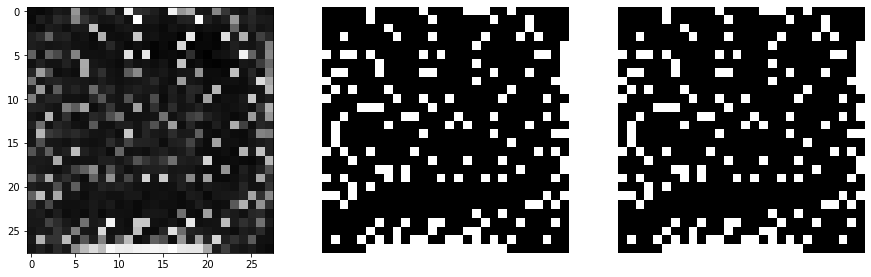

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0032
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0036
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0031
test at the end of epoch

Test set: Avg. loss: 0.0025


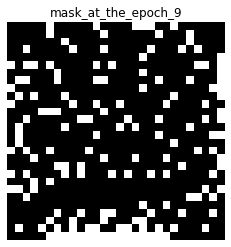

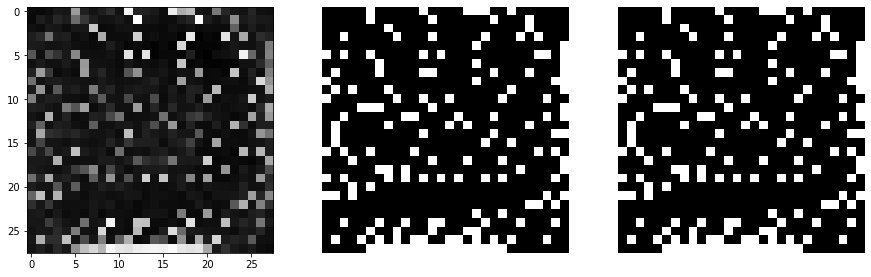

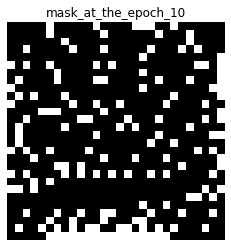

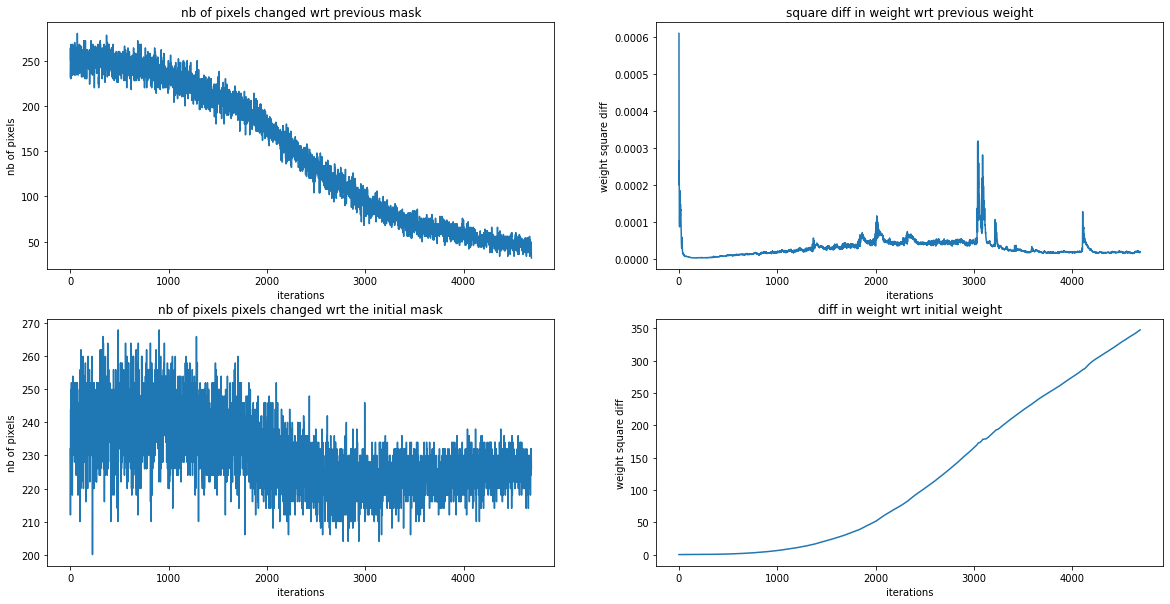

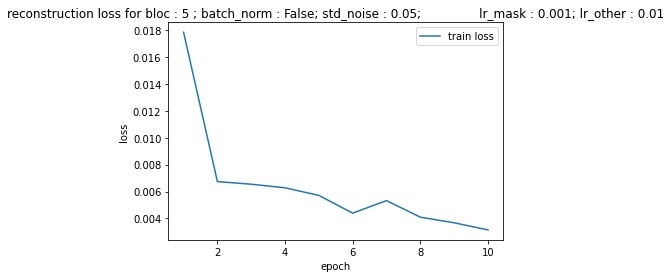

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0025


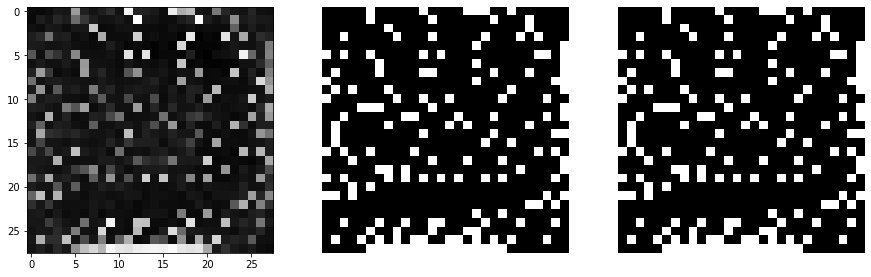

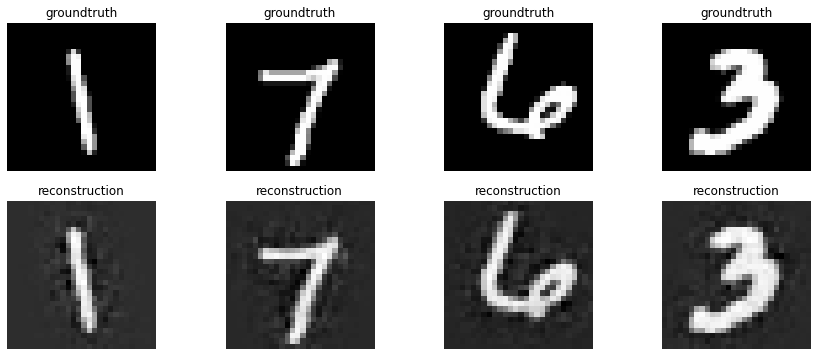

average ssim and psnr on test set {'test_ssim': 0.9463400134542035, 'test_psnr': 25.629697394525188}
##########   FIN   ##########


In [33]:
##usage de new net
spirit_config_1 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 8, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": True,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :False
}

spirit_config_1 =edict(spirit_config_1)

model1= make_grid_search_4(spirit_config_1, spirit_block_list=[5], std_noise_list=[0.05], bn_list=[False], lr_mask_list=[1e-3], lr_other_list=[1e-2], critere = nn.MSELoss(), return_model =True )


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0025


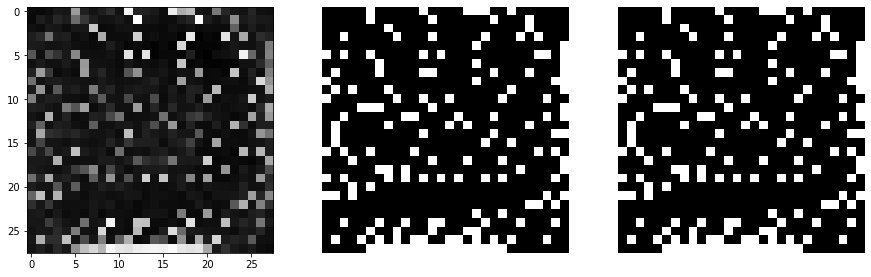

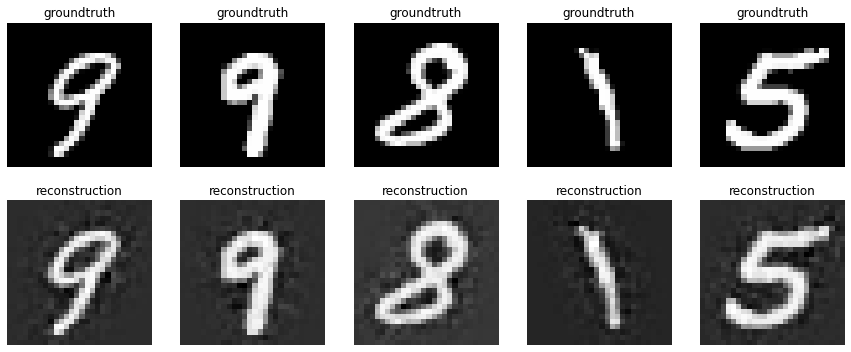

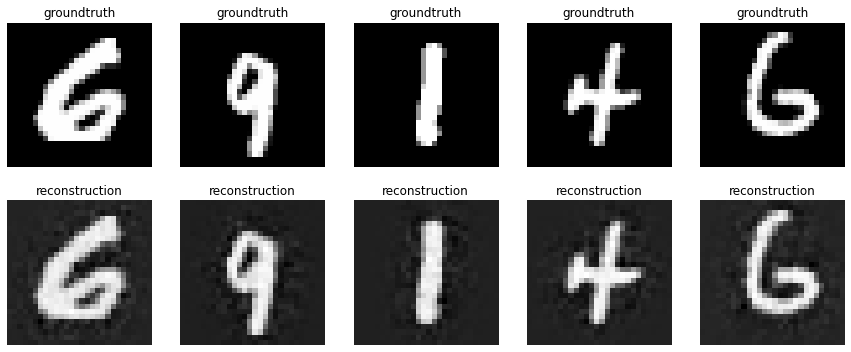

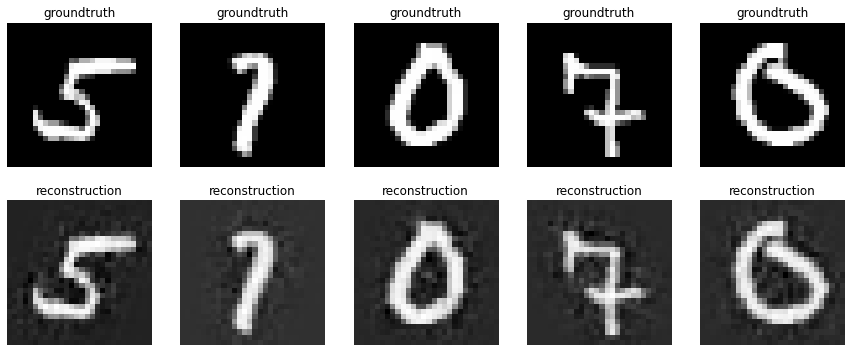

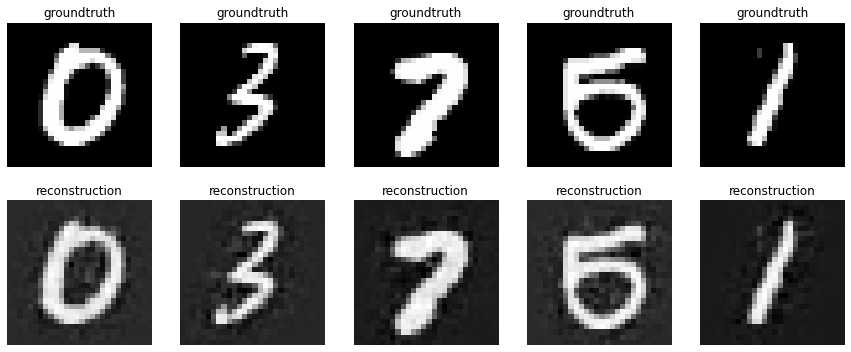

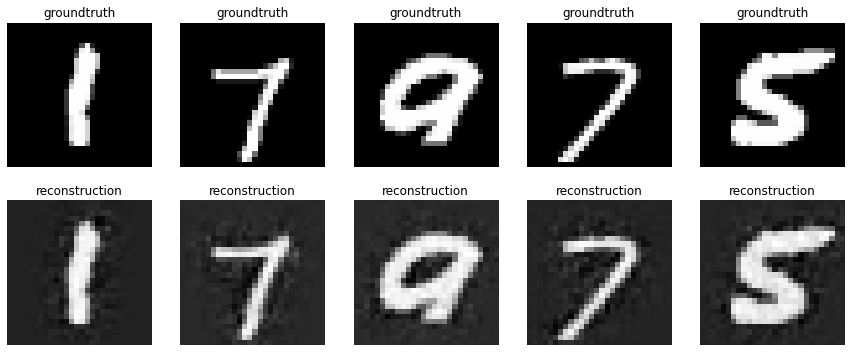

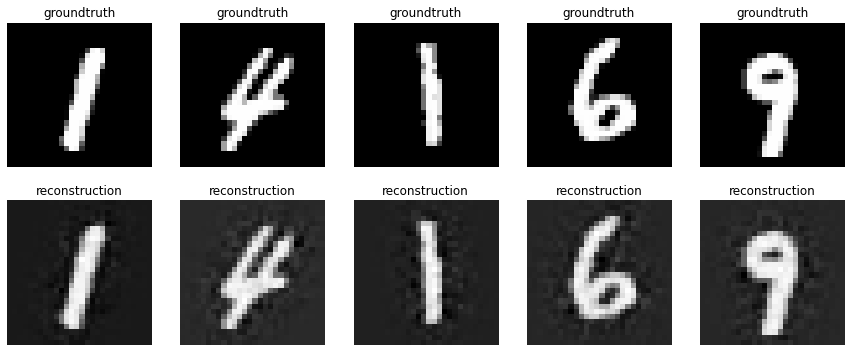

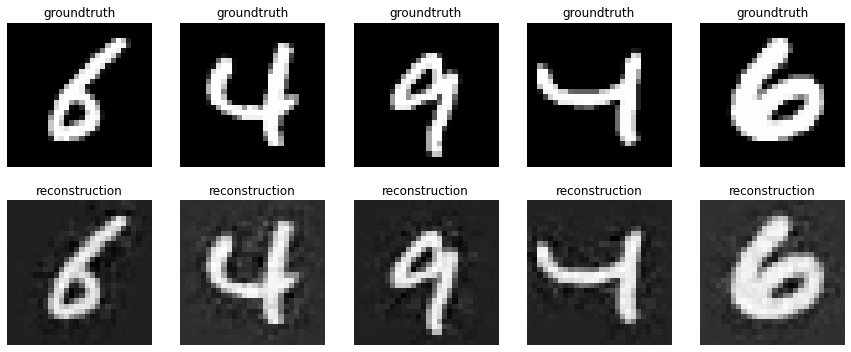

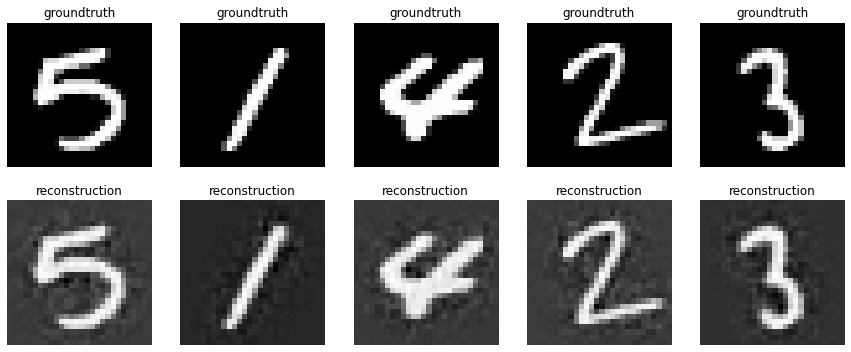

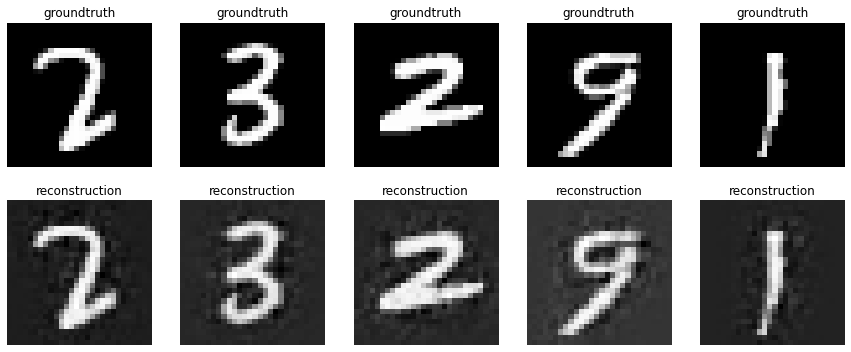

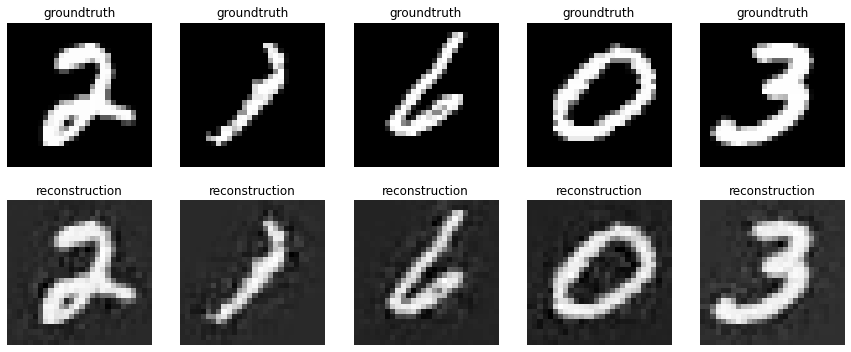

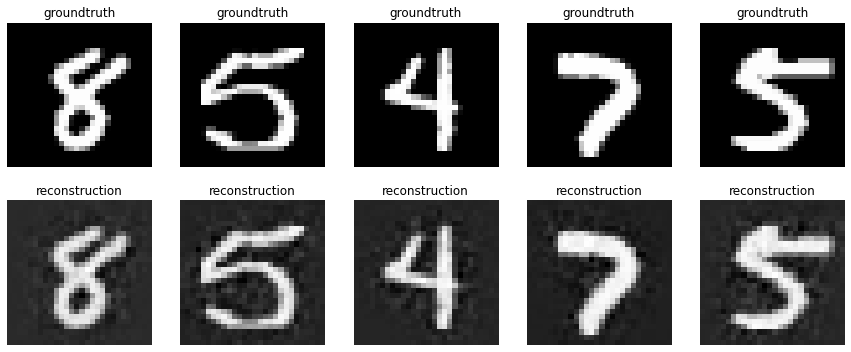

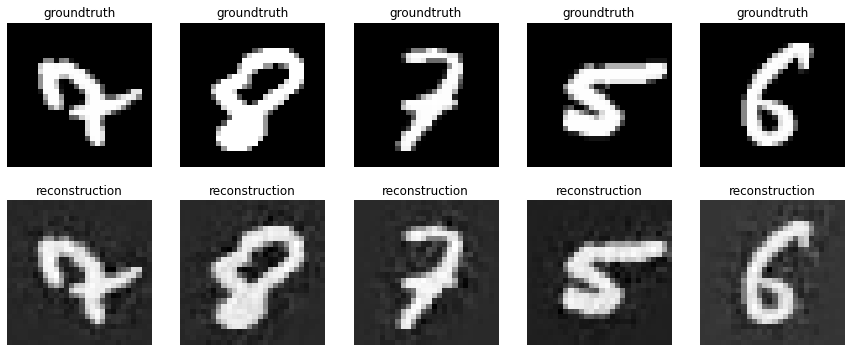

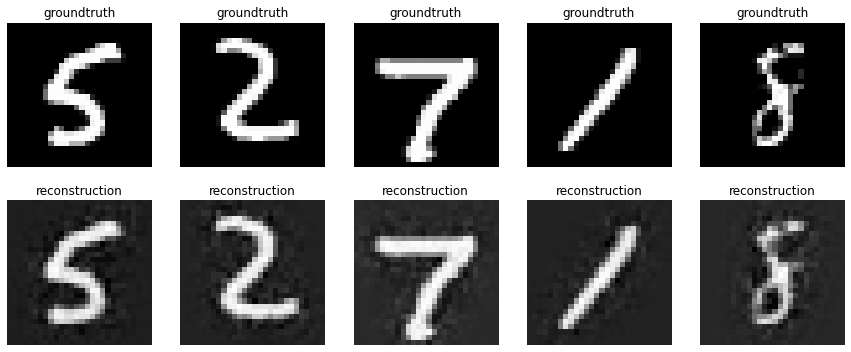

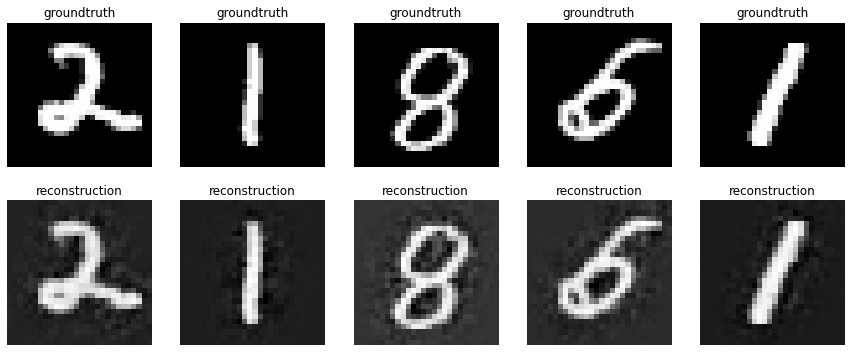

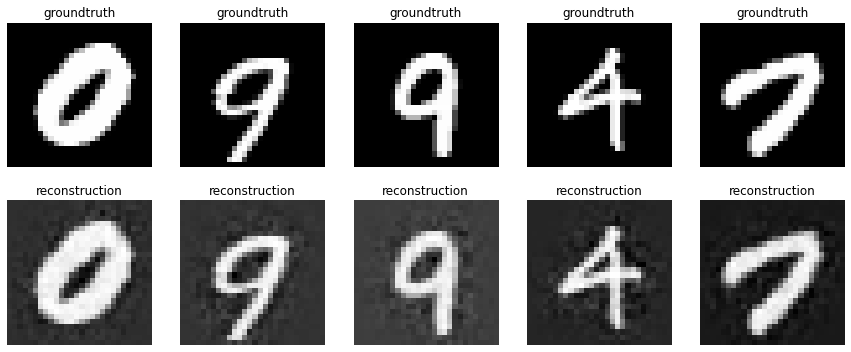

In [34]:
input_array, output_array, test_loss, learned_mask_adj = test_spirit_2(model1[0],criterion = nn.MSELoss(), config = spirit_config_1, loader=test_loader)

for i in range(15):
  plotting_reconst(input_array, output_array,n=5, seed= None, saving_path =None, )

 
## <font color='darkblue'> basic model</font>


#################################################################
spirit_bloc : 5 ; batch_norm : False; std_noise : 0.05; lr_mask : 0.001; lr_other : 0.01
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.0983
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0281
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0244
test at the end of epoch

Test set: Avg. loss: 0.0268


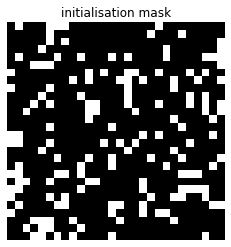

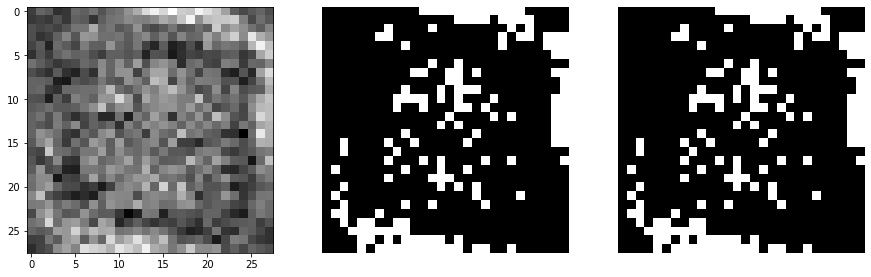

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0246
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0241
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0224
test at the end of epoch

Test set: Avg. loss: 0.0196


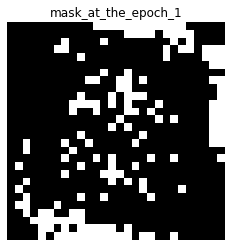

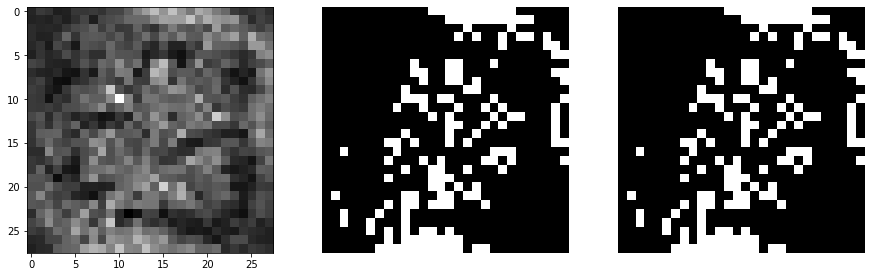

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0223
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0221
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0210
test at the end of epoch

Test set: Avg. loss: 0.0194


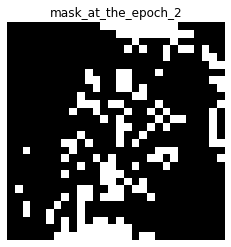

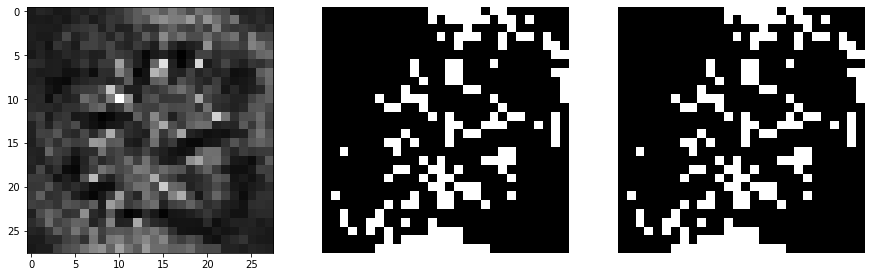

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0198
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0195
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0206
test at the end of epoch

Test set: Avg. loss: 0.0205


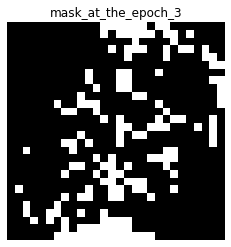

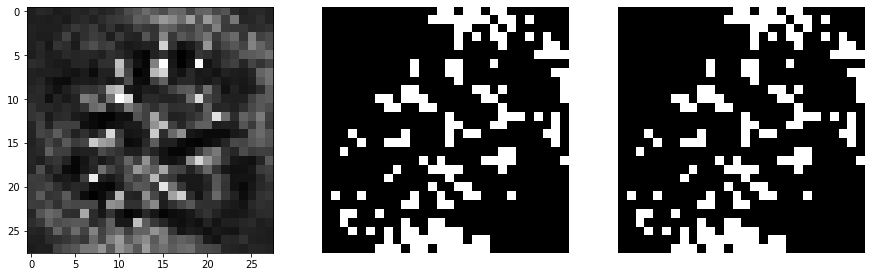

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0210
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0219
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0221
test at the end of epoch

Test set: Avg. loss: 0.0226


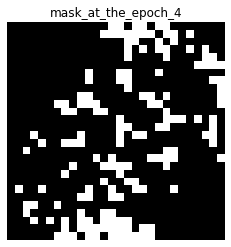

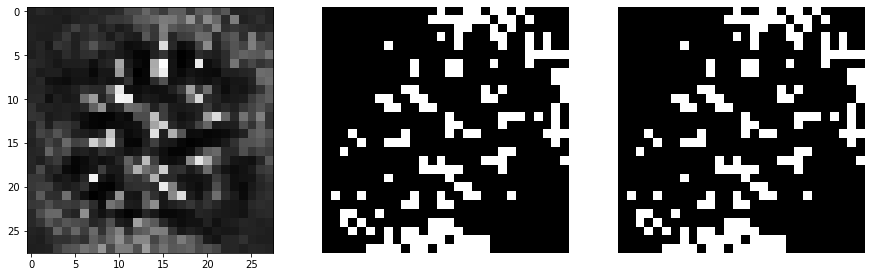

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0231
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0232
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0243
test at the end of epoch

Test set: Avg. loss: 0.0241


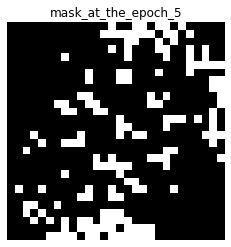

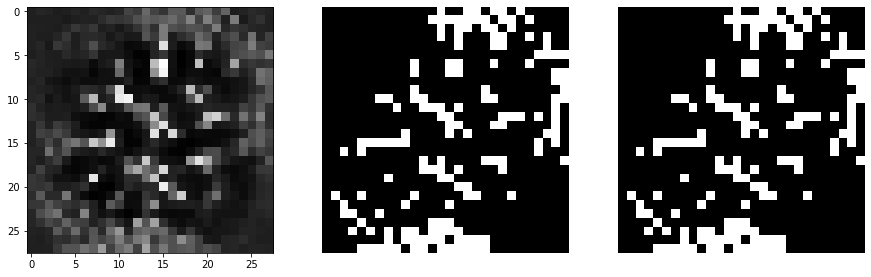

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0249
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0260
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0246
test at the end of epoch

Test set: Avg. loss: 0.0246


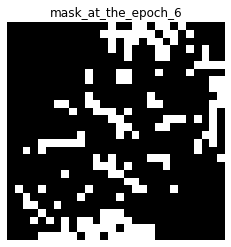

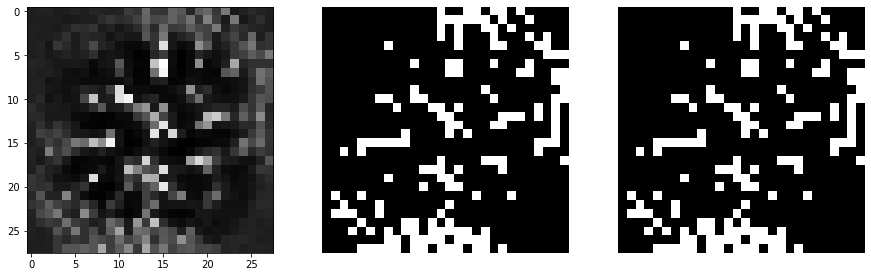

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0244
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0253
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0280
test at the end of epoch

Test set: Avg. loss: 0.0258


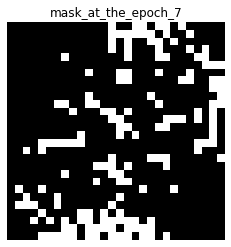

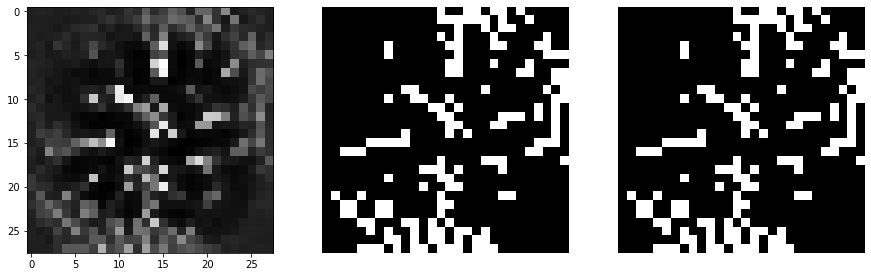

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0256
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0281
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0304
test at the end of epoch

Test set: Avg. loss: 0.0277


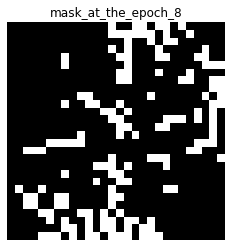

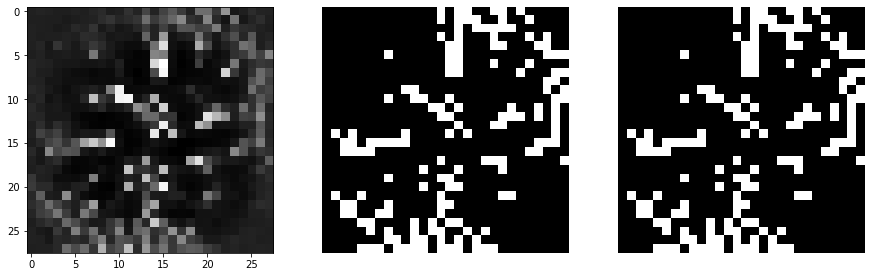

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0277
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0276
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0282
test at the end of epoch

Test set: Avg. loss: 0.0282


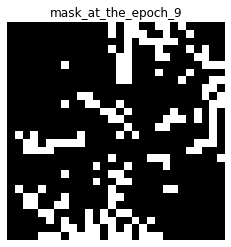

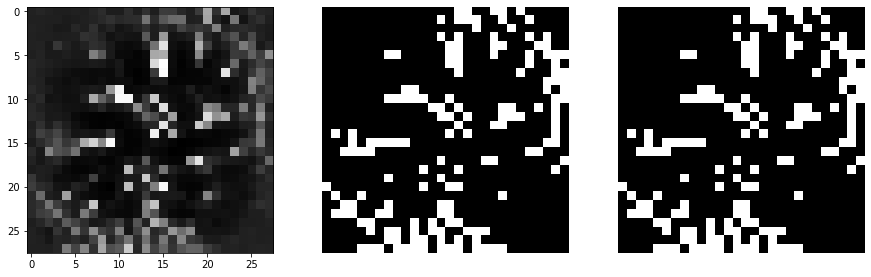

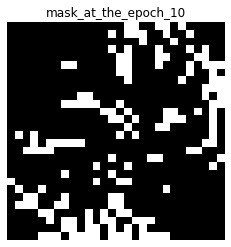

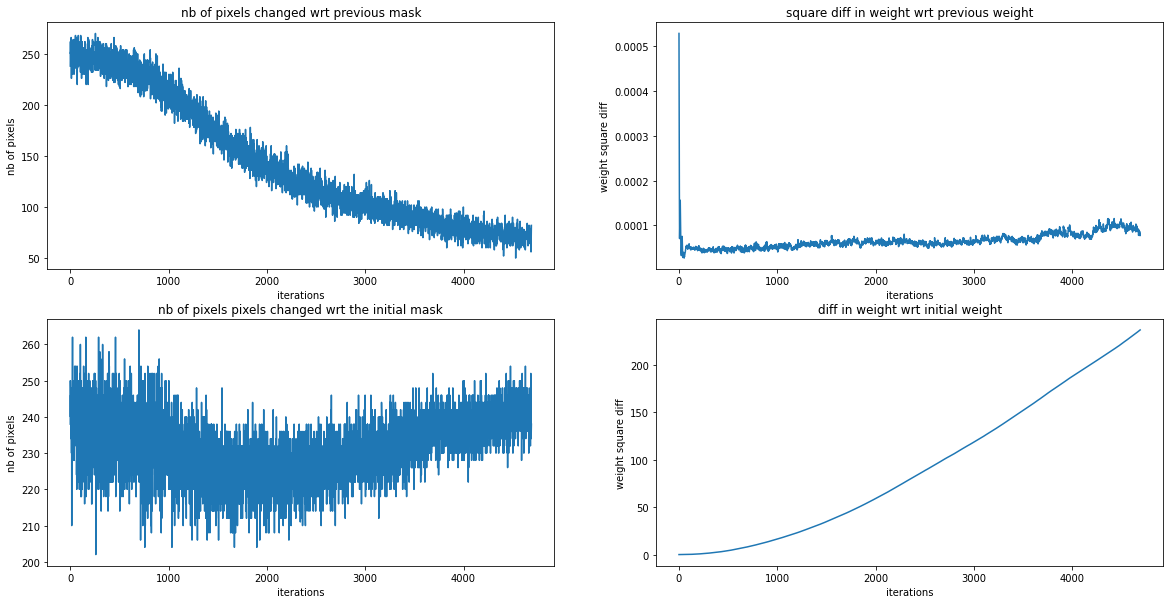

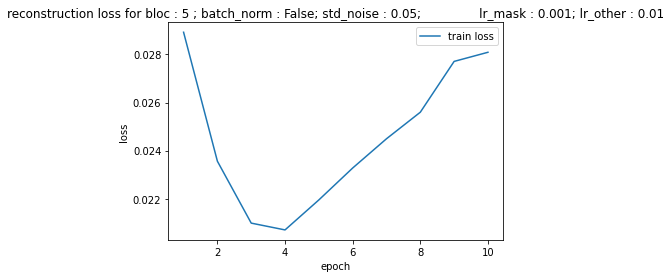

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0282


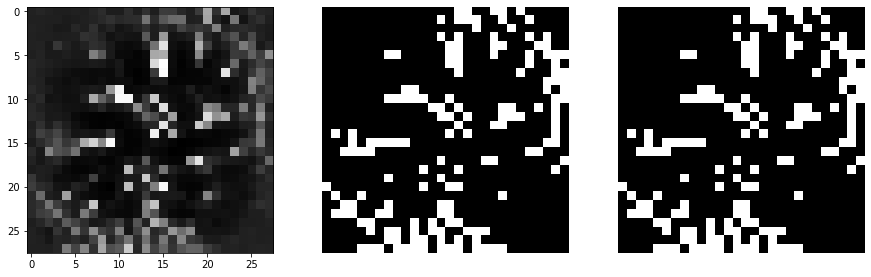

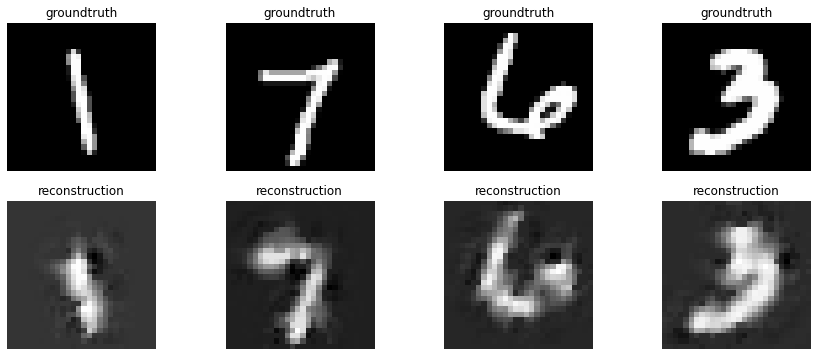

average ssim and psnr on test set {'test_ssim': 0.7168860391888542, 'test_psnr': 16.349866403830028}
##########   FIN   ##########
CPU times: user 10min, sys: 11.8 s, total: 10min 12s
Wall time: 10min 24s


In [42]:
%%time

spirit_config_without_aux_loss = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": False,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :False
}

make_grid_search_4(spirit_config_without_aux_loss, spirit_block_list=[5], std_noise_list=[0.05], bn_list=[False], lr_mask_list=[1e-3], lr_other_list=[1e-2], critere = nn.MSELoss())
